# Modelling PDBP Data

The purpose of this is to bring in the data, model, transform and output

In [1]:
from PDBPfunctions import *
import upsetplot
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
   # warnings.simplefilter("default")

/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


Set paths

In [3]:
p_dat="/Users/michaelallwright/Documents/python/PDBP/Project Final/data/"
p_an="/Users/michaelallwright/Documents/python/PDBP/Project Final/analysis/"
p_unb="/Users/michaelallwright/Documents/python/PDBP/Project Final/data/Post Unblind/"

### Import lookup from sample id as per RNA file to sample name and diagnosis

In [4]:
nih_lkup= pd.read_excel ('%s%s' % (p_dat,"Mapping Sample to Diagnosis 20200122.xlsx"),sheet_name='Calcs')

#### Bring in RNA data 

In [5]:
NIH_RNA=pd.read_csv("%s%s" % (p_dat,"nih_full_t20200124.csv"))


Merge together on relevant sample variable

In [6]:
nih_full_int_t=pd.merge(NIH_RNA,nih_lkup,left_on='sample',right_on='RNAFileName',how='left')
#nih_full_int_t.sample(5)

Filter on HC and PD

In [7]:
nih_mod_data_HCPD=nih_full_int_t[(nih_full_int_t['Diagnosis']=="HC")|(nih_full_int_t['Diagnosis']=="PD")]

In [8]:
#Below is just for set A
nih_mod_data_HCPDA=nih_mod_data_HCPD[(nih_mod_data_HCPD['Sample Set']=="A")]

Set arrays for modelling

In [9]:
X=np.asarray(nih_mod_data_HCPD.drop(['sample', 'RNAFileName','BarCode1', 'Position','Combination','Sample_name',
                                     'Specimen barcode','GUID','Diagnosis from GUID file',
                                     'Diagnosis short from GUID file','Diagnosis','check','Sample Set'],axis=1))
y=np.asarray(nih_mod_data_HCPD['Diagnosis short from GUID file'])

Xa=np.asarray(nih_mod_data_HCPDA.drop(['sample', 'RNAFileName','BarCode1', 'Position','Combination','Sample_name',
                                     'Specimen barcode','GUID','Diagnosis from GUID file',
                                     'Diagnosis short from GUID file','Diagnosis','check','Sample Set'],axis=1))
ya=np.asarray(nih_mod_data_HCPDA['Diagnosis short from GUID file'])


Transform

In [10]:
scaler = StandardScaler()
sf=scaler.fit(X)
sfa=scaler.fit(Xa)

X_s=sf.transform(X)
X_as=sfa.transform(Xa)

Models

In [11]:
from sklearn import linear_model
xgb_gs1=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=None, subsample=1, verbosity=1)

xgb_gs2=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=60, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=None, subsample=1, verbosity=1)

xgb_gs3=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=60, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=None, subsample=1, verbosity=1)


sgd=linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)

names = ["AdaBoost","Bernoulli NB","Decision Tree", "Gauss Proc","Log Reg","KNN", "Naive Bayes","Neural Net","QDA","Random Forest","SGD","Linear SVM",
         "XGBoost","XGB_gs1","XGB_gs2","XGB_gs3"]#],"rf_gs"]
classifiers = [ AdaBoostClassifier(),BernoulliNB(alpha=0.1),DecisionTreeClassifier(max_depth=4), GaussianProcessClassifier(), LogisticRegression(random_state=0, solver='lbfgs'),KNeighborsClassifier(7), GaussianNB(),
               
                MLPClassifier(alpha=1, max_iter=1000), QuadraticDiscriminantAnalysis(), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=5),sgd,
               SVC(kernel="linear", C=0.025,probability=True),xgb.XGBClassifier(random_state=1,learning_rate=0.01),xgb_gs1,xgb_gs2,xgb_gs3]#],rf2]    


names_sub=["BernoulliNB"]
classifiers_sub = [XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)]

classifiers_sub=[BernoulliNB(alpha=0.1)]

Model nested cross fold validation on the UMap dimensional reduced data

[[-1.0285734   0.15041855  0.57022846 ... -0.8292362   0.9583408
   0.652638  ]
 [-1.1279161   0.06513893  0.51151925 ... -0.8640595   0.862627
   0.6293806 ]
 [-0.91277355  0.29957366  0.5729128  ... -0.7732519   1.0268553
   0.6466086 ]
 ...
 [-1.5095192  -1.3150707  -0.8788501  ...  0.11292933 -0.6052804
  -0.07885344]
 [-0.6559414   0.3723102   0.56934744 ... -0.54671854  0.6231889
   0.5971278 ]
 [-1.6826757   1.037077    0.512694   ... -1.6574967   0.7344542
   0.6210458 ]]


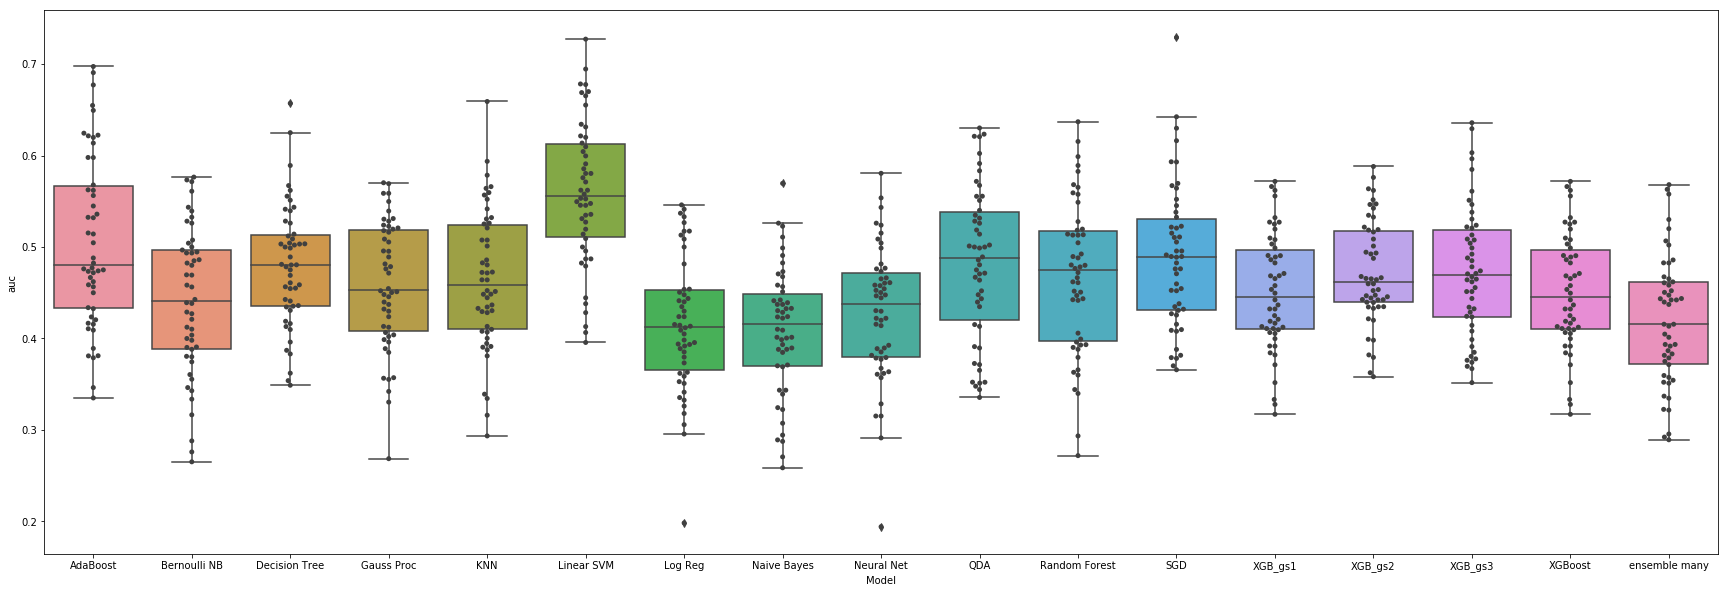

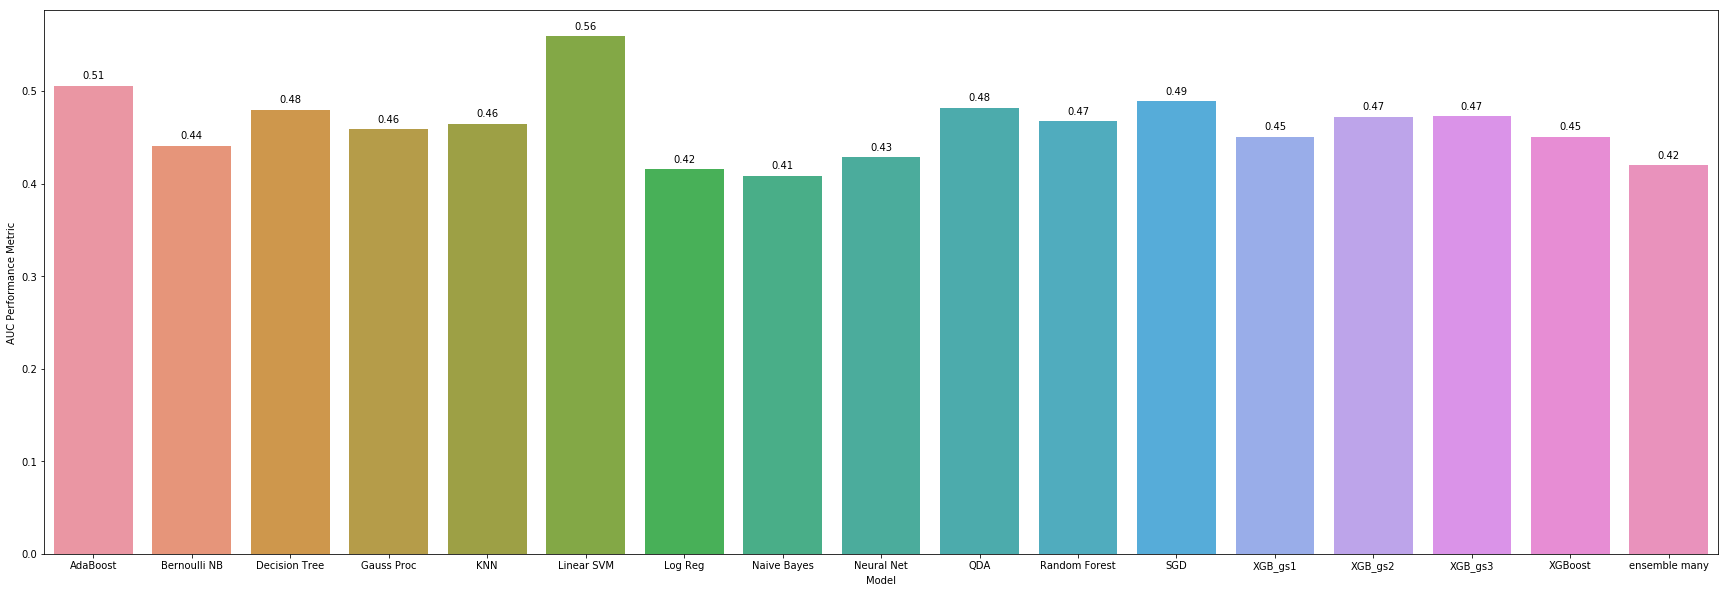

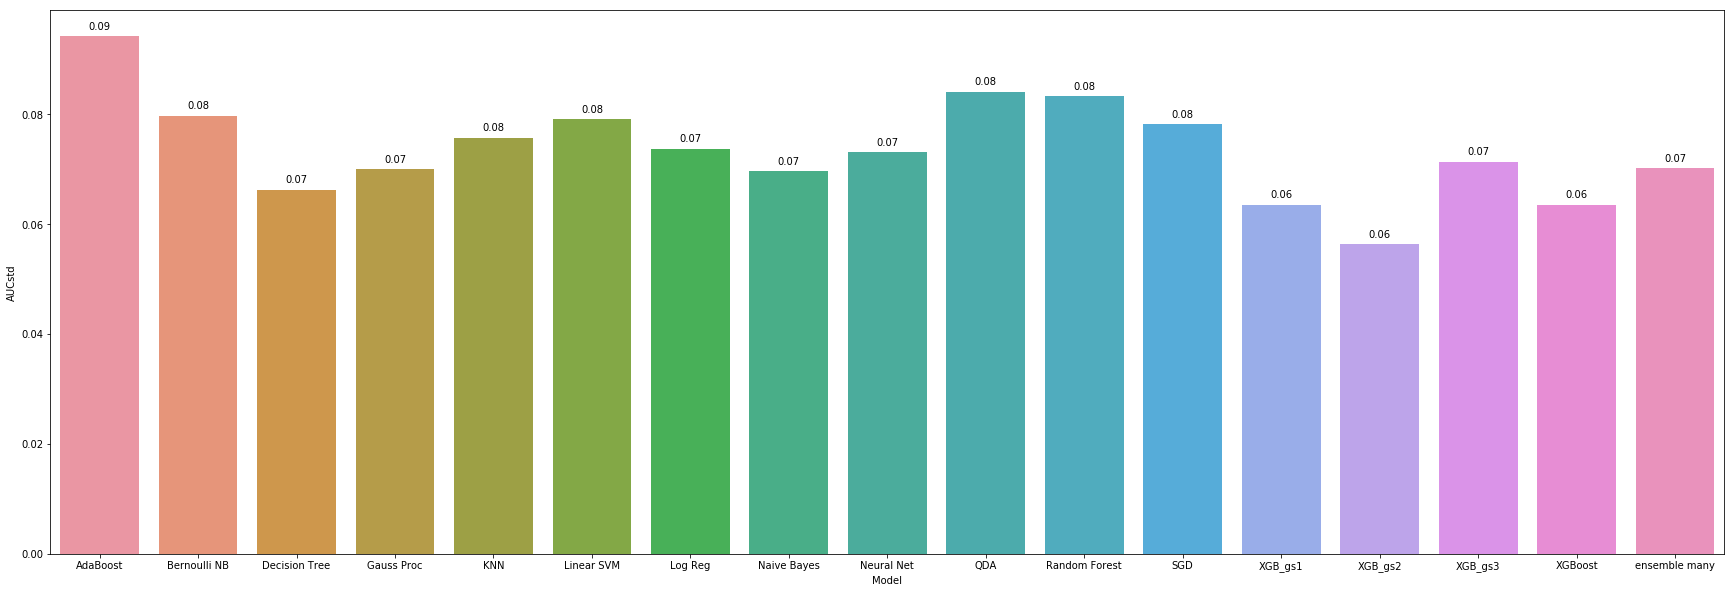

In [12]:
testing_data_umap,mod_sum_umap=ncvmodel(X_s,y,"UMap",names,classifiers,p_an,y_var="PD",name="check",reps=10,umap_c=30,um_neigh=5,pca_comp=20,n_splits=5)

Model nested cross fold validation on all variables in dataset

In [ ]:
testing_data_umap,mod_sum_umap=ncvmodel(X_s,y,"None",names,classifiers,p_an,y_var="PD",name="check",reps=10,umap_c=30,um_neigh=5,pca_comp=20,n_splits=5)